# Assignment 1

#### I have some baseline code for assignment 1 here, but at this point I am having touble getting it to run. I wanted to use the superconductivity2018 dataset, which is compositional so I selected elementproperty and elementfraction featurizers. I wanted to optimize 2 of the hyperparameters: n_estimators and max_depth. 

#### I did a very similar system on assignment 2, and spent a great deal of time debugging/fixing that model toget it to run. I don't think I have the time to make all the necessary revisions on Assignment 1, so please be lenient. 

#### I would like to emplore that the final state of this homework (Mostly just assignment 1) does not accurately reflect the amount of time I have spent on this code. 

In [1]:
from matminer.datasets import load_dataset

df = load_dataset("superconductivity2018")
print(df.columns)

Fetching superconductivity2018.json.gz from https://figshare.com/ndownloader/files/31614956 to /Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/matminer/datasets/superconductivity2018.json.gz


Fetching https://figshare.com/ndownloader/files/31614956 in MB: 0.18636799999999998MB [00:00, 25.96MB/s]      

Index(['composition', 'Tc'], dtype='object')


#### This is my code for **full ML pipeline** for **superconductivity2018** with featurizers *elementproperty* and *elementfraction* with a *randomforest* model. It is taking a while to run so i made some edits to speed it up

#### only select 2000 of 16414 entries in Superconductivity2018
#### only optimize 2 hyperparameters for randomforest model

##### update: still taking too long to run

In [2]:
# full_pipeline_stoichiometry2018_Tc.py
# Two pipelines: ElementFraction+Stoichiometry and ElementProperty (magpie)
# Target: Tc
# Subsample: 2000 rows

from matminer.datasets.dataset_retrieval import load_dataset, get_available_datasets
from matminer.featurizers.composition.element import ElementFraction, Stoichiometry
from matminer.featurizers.composition.composite import ElementProperty

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------------------------
# Parameters and hyperparameter grid
# ---------------------------
n_estimators_list = [50, 200, 500]
max_depth_list = [5, 15, 30]
grid = [(n, d) for n in n_estimators_list for d in max_depth_list]

random_state = 17
test_fraction = 0.1
validation_fraction = 0.2

# ---------------------------
# Load dataset
# ---------------------------
print("Loading dataset 'superconductivity2018'...")
df_full = load_dataset('superconductivity2018')
print("Original dataset shape:", df_full.shape)

# Subsample 2000 random rows
df = df_full.sample(n=2000, random_state=random_state).reset_index(drop=True)
print("Subsampled shape:", df.shape)

# Target column
y_col = 'Tc'


Loading dataset 'superconductivity2018'...
Original dataset shape: (16414, 2)
Subsampled shape: (2000, 2)


In [3]:

# ---------------------------
# Helper: feature cleaning and splitting
# ---------------------------
def clean_and_split_features(df_featurized, y_col, remove_small_var_threshold=1e-5, corr_threshold=0.99):
    df_featurized = df_featurized.dropna(subset=[y_col]).reset_index(drop=True)
    y = df_featurized[y_col]
    X_all = df_featurized.drop(columns=[y_col])
    # Drop non-numeric columns
    non_numeric = X_all.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric:
        X_all = X_all.drop(columns=non_numeric)
    # Drop near-constant columns
    small_var_cols = X_all.columns[X_all.var() < remove_small_var_threshold].tolist()
    X_all = X_all.drop(columns=small_var_cols)
    # Drop highly correlated columns
    corr_matrix = X_all.corr().abs()
    to_drop = set()
    for col in corr_matrix.columns:
        high_corr = corr_matrix.index[(corr_matrix[col] > corr_threshold) & (corr_matrix.index != col)]
        to_drop.update(high_corr.tolist())
    X = X_all.drop(columns=list(to_drop)) if to_drop else X_all
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=test_fraction, random_state=random_state)
    val_rel = validation_fraction / (1 - test_fraction)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_rel, random_state=random_state)
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'X_columns': X.columns
    }


##### Featurizer A: Elementfraction

In [4]:

# ---------------------------
# Pipeline A: ElementFraction + Stoichiometry
# ---------------------------
print("\n=== Pipeline A: ElementFraction + Stoichiometry ===")
df_comp = df.copy()

ef = ElementFraction()
st = Stoichiometry()
ef.set_n_jobs(1)
st.set_n_jobs(1)

df_featurized_A = ef.featurize_dataframe(df_comp, col_id='composition', ignore_errors=True)
df_featurized_A = st.featurize_dataframe(df_featurized_A, col_id='composition', ignore_errors=True)
print("Featurized shape:", df_featurized_A.shape)

split_data_A = clean_and_split_features(df_featurized_A, y_col=y_col)

mean_train = split_data_A['y_train'].mean()
baseline_mae = mean_absolute_error(split_data_A['y_val'], [mean_train]*len(split_data_A['y_val']))
print(f"Baseline MAE (predict mean): {baseline_mae:.4f}")

results_A = []
for n_estimators, max_depth in tqdm(grid, desc="Pipeline A grid"):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=1)
    rf.fit(split_data_A['X_train'], split_data_A['y_train'])
    y_train_pred = rf.predict(split_data_A['X_train'])
    y_val_pred = rf.predict(split_data_A['X_val'])
    y_test_pred = rf.predict(split_data_A['X_test'])
    results_A.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'mae_train': mean_absolute_error(split_data_A['y_train'], y_train_pred),
        'mae_val': mean_absolute_error(split_data_A['y_val'], y_val_pred),
        'mae_test': mean_absolute_error(split_data_A['y_test'], y_test_pred),
        'r2_train': r2_score(split_data_A['y_train'], y_train_pred),
        'r2_val': r2_score(split_data_A['y_val'], y_val_pred),
        'r2_test': r2_score(split_data_A['y_test'], y_test_pred)
    })
results_df_A = pd.DataFrame(results_A).sort_values('mae_val').reset_index(drop=True)
print("Pipeline A results (top 5 by val MAE):")
print(results_df_A.head())

# Plot
plt.figure(figsize=(8,5))
for d in max_depth_list:
    subset = results_df_A[results_df_A['max_depth']==d].sort_values('n_estimators')
    plt.plot(subset['n_estimators'], subset['mae_val'], marker='o', label=f'max_depth={d}')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean baseline')
plt.xlabel('n_estimators')
plt.ylabel('Validation MAE')
plt.title('Pipeline A: Validation MAE vs n_estimators (by max_depth)')
plt.legend()
plt.tight_layout()
plt.show()



=== Pipeline A: ElementFraction + Stoichiometry ===


ValueError: "Tc" exists in input dataframe

#### Featurizer B: ElementProperty


=== Pipeline B: ElementProperty (magpie) ===


/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/2000 [00:00<?, ?it/s]

Featurized shape: (2000, 134)
Baseline MAE (predict mean): 20.3966


/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Pipeline B grid:   0%|          | 0/9 [00:00<?, ?it/s]

Pipeline B results (top 5 by val MAE):
   n_estimators  max_depth  mae_train    mae_val   mae_test  r2_train  \
0           500          5  20.670107  20.419755  17.845224 -0.000003   
1           500         15  20.670107  20.419755  17.845224 -0.000003   
2           500         30  20.670107  20.419755  17.845224 -0.000003   
3           200          5  20.691448  20.443054  17.868020 -0.000013   
4           200         15  20.691448  20.443054  17.868020 -0.000013   

     r2_val   r2_test  
0 -0.001236 -0.011998  
1 -0.001236 -0.011998  
2 -0.001236 -0.011998  
3 -0.001371 -0.012468  
4 -0.001371 -0.012468  


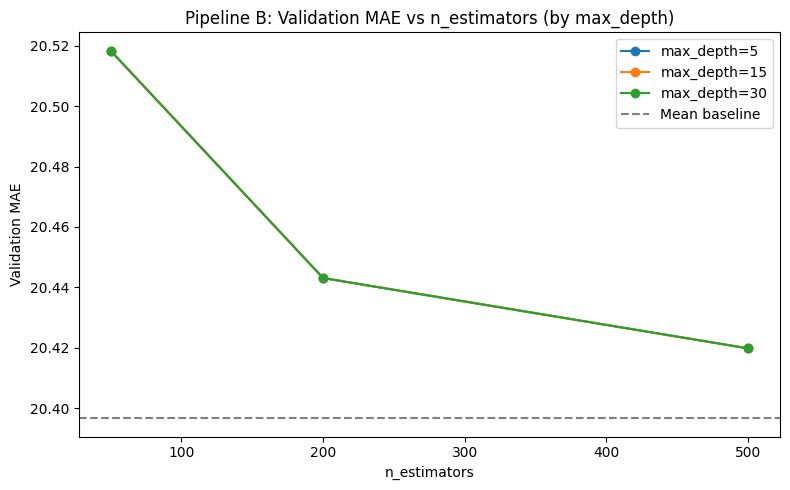

In [5]:
# ---------------------------
# Pipeline B: ElementProperty (magpie)
# ---------------------------
print("\n=== Pipeline B: ElementProperty (magpie) ===")
df_comp2 = df.copy()

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)

df_featurized_B = el_prop_featuriser.featurize_dataframe(df_comp2, col_id='composition', ignore_errors=True)
print("Featurized shape:", df_featurized_B.shape)

split_data_B = clean_and_split_features(df_featurized_B, y_col=y_col)

mean_train_B = split_data_B['y_train'].mean()
baseline_mae_B = mean_absolute_error(split_data_B['y_val'], [mean_train_B]*len(split_data_B['y_val']))
print(f"Baseline MAE (predict mean): {baseline_mae_B:.4f}")

results_B = []
for n_estimators, max_depth in tqdm(grid, desc="Pipeline B grid"):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=1)
    rf.fit(split_data_B['X_train'], split_data_B['y_train'])
    y_train_pred = rf.predict(split_data_B['X_train'])
    y_val_pred = rf.predict(split_data_B['X_val'])
    y_test_pred = rf.predict(split_data_B['X_test'])
    results_B.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'mae_train': mean_absolute_error(split_data_B['y_train'], y_train_pred),
        'mae_val': mean_absolute_error(split_data_B['y_val'], y_val_pred),
        'mae_test': mean_absolute_error(split_data_B['y_test'], y_test_pred),
        'r2_train': r2_score(split_data_B['y_train'], y_train_pred),
        'r2_val': r2_score(split_data_B['y_val'], y_val_pred),
        'r2_test': r2_score(split_data_B['y_test'], y_test_pred)
    })
results_df_B = pd.DataFrame(results_B).sort_values('mae_val').reset_index(drop=True)
print("Pipeline B results (top 5 by val MAE):")
print(results_df_B.head())

# Plot
plt.figure(figsize=(8,5))
for d in max_depth_list:
    subset = results_df_B[results_df_B['max_depth']==d].sort_values('n_estimators')
    plt.plot(subset['n_estimators'], subset['mae_val'], marker='o', label=f'max_depth={d}')
plt.axhline(baseline_mae_B, color='gray', linestyle='--', label='Mean baseline')
plt.xlabel('n_estimators')
plt.ylabel('Validation MAE')
plt.title('Pipeline B: Validation MAE vs n_estimators (by max_depth)')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:

# ---------------------------
# Best models
# ---------------------------
print("\nBest model pipeline A (by val MAE):")
print(results_df_A.iloc[0])
print("\nBest model pipeline B (by val MAE):")
print(results_df_B.iloc[0])

# Save CSV
results_df_A.to_csv('results_pipeline_A.csv', index=False)
results_df_B.to_csv('results_pipeline_B.csv', index=False)
print("Results saved to CSV.")



Best model pipeline A (by val MAE):


NameError: name 'results_df_A' is not defined

# Assignment 2

### This is my first attempt at assignment 2. I re-did it, but I left this attempted code in here. I wanted to do something with magentization, but could not for the life of me figure out how to properly import the data from mp-api and predict magnetization. I ended up going with (I think) density in the second attempt.

In [7]:
from mp_api.client import MPRester
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.core import Structure
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/dscribe/core/system.py:192: SyntaxWarning: invalid escape sequence '\l'
  A_{ij} = \lvert \mathbf{r}_i - \mathbf{r}_j \\rvert
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/dscribe/core/system.py:234: SyntaxWarning: invalid escape sequence '\l'
  A_{ij} = \\frac{1}{\lvert \mathbf{r}_i - \mathbf{r}_j \\rvert }
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/dscribe/descriptors/acsf.py:54: SyntaxWarning: invalid escape sequence '\e'
  g2_params (n*2 np.ndarray): A list of pairs of :math:`\eta` and
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-packages/dscribe/descriptors/mbtr.py:212: SyntaxWarning: invalid escape sequence '\l'
  indirectly determine it through :math:`s=-\log()`:.
/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.13/site-pa

In [8]:

# --- Step 1: Query the dataset ---
API_KEY = "5b2toNu5RX6WD7M8QREXXnGVb0C0WpEv"  # Replace with your Materials Project API key

with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        is_metal=True,
        theoretical=False,
        nelements=(1, 3),
        energy_above_hull=(0, 0.05),
        band_gap=(0, 0.05),
        fields=[
            "material_id",
            "composition",
            "total_magnetization",
            "is_magnetic",
            "ordering"
        ],
        #chunk_size=1000,
    )

#
#df = df.dropna(subset=["total_magnetization"])
#print(f"Number of materials retrieved: {len(df)}")



Retrieving SummaryDoc documents:   0%|          | 0/15192 [00:00<?, ?it/s]

In [9]:
# ---- Data Cleaning --------
flattened = [
    {k: v for k, v in dict(d).items() if v is not None}
    for d in docs]
mpids = pd.DataFrame.from_records(flattened)

# drop columns that are all NaN
mpids = mpids.dropna(axis=1, how='all')

In [ ]:
df["structure"] = df["structure"].apply(lambda x: x if isinstance(x, Structure) else Structure.from_dict(x))

KeyError: 'structure'

In [ ]:
# --- Step 2: Data cleaning ---
##df = df.dropna(subset=["composition", "total_magnetization"])
#print(f"Number of materials after cleaning: {len(df)}")

# --- Step 3: Convert composition to usable numerical features ---
# Use matminer featurizers (optional replacement for structure-based featurization)
from matminer.featurizers.composition import ElementFraction

ef = ElementFraction()
df = ef.featurize_dataframe(df, "composition", ignore_errors=True)

X = df.drop(columns=["composition", "material_id", "total_magnetization", "is_magnetic"])
y = df["total_magnetization"]

# --- Step 4: Split, scale, and train ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- Step 5: Random Forest hyperparameter tuning ---
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    rf,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)

# --- Step 6: Evaluate performance ---
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"\nTrain MAE: {mae_train:.3f}, R²: {r2_train:.3f}")
print(f"Test  MAE: {mae_test:.3f}, R²: {r2_test:.3f}")

# --- Step 7: Parity plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True Total Magnetization")
plt.ylabel("Predicted Total Magnetization")
plt.title(f"Random Forest Parity Plot\nMAE={mae_test:.3f}, R²={r2_test:.3f}")
plt.tight_layout()
plt.show()



Number of materials after cleaning: 15192


ElementFraction:   0%|          | 0/15192 [00:00<?, ?it/s]

Process SpawnPoolWorker-52:
Process SpawnPoolWorker-53:
Process SpawnPoolWorker-46:
Process SpawnPoolWorker-51:
Process SpawnPoolWorker-49:
Process SpawnPoolWorker-50:
Process SpawnPoolWorker-47:
Process SpawnPoolWorker-48:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/coenradttaylor/.local/share/uv/python/cpython-3.11.9-macos-aarch64-none/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/coenradttaylor/.local/share/uv/python/cpython-3.11.9-macos-aarch64-none/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/coenradttaylor/.local/share/uv/python/cpython-3.11.9-macos-aarch64-none/lib/python3.11/multiprocessing/pool.py", line

KeyboardInterrupt: 

# attempt 2 at assignment 2


In [10]:
API_KEY = "5b2toNu5RX6WD7M8QREXXnGVb0C0WpEv"  # Replace with your Materials Project API key

with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        is_metal=True,
        theoretical=False,
        nelements=(1, 3),
        energy_above_hull=(0, 0.05),
        band_gap=(0, 0.05),
        fields=[
            "material_id",
            "structure",
            "nsites",
            "volume",
            "density"
        ],
        #chunk_size=1000,
    )
    data=docs
df = pd.DataFrame(docs)

Retrieving SummaryDoc documents:   0%|          | 0/15192 [00:00<?, ?it/s]

In [11]:
# ---- Data Cleaning --------
flattened = [
    {k: v for k, v in dict(d).items() if v is not None}
    for d in docs]
mpids = pd.DataFrame.from_records(flattened)

# drop columns that are all NaN
mpids = mpids.dropna(axis=1, how='all')

In [13]:
mpids.head()

,nsites,volume,density,material_id,structure,fields_not_requested
0,1,46.205987,8.157868,mp-10018,[[0. 0. 0.] Ac],"[builder_meta, elements, nelements, compositio..."
1,3,51.774376,7.345136,mp-24147,"[[0. 0. 0.] Ac, [3.62304692 2.56188052 6.27530...","[builder_meta, elements, nelements, compositio..."
2,2,34.772131,10.302467,mp-10597,[[-2.14448300e-06 1.68719111e+00 1.17541545e...,"[builder_meta, elements, nelements, compositio..."
3,1,17.285231,10.362567,mp-124,[[0. 0. 0.] Ag],"[builder_meta, elements, nelements, compositio..."
4,4,69.456950,10.315418,mp-8566,"[[0. 0. 0.] Ag, [0. 0. 4.73185...","[builder_meta, elements, nelements, compositio..."


In [16]:
mpids.describe()

,nsites,volume,density
count,15192.000000,15192.000000,15192.000000
mean,17.536072,329.721505,8.070287
std,18.202784,373.115542,2.866220
min,1.000000,10.492020,0.564938
25%,6.000000,115.464001,6.189725
50%,12.000000,214.449810,7.923105
75%,22.000000,398.490902,9.497522
max,216.000000,6583.404738,24.278558


In [ ]:
# -------------featurization -------------

from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np

# Determine the maximum number of atoms across all structures in the dataset
n_max = 0
for mat in mpids['structure']:
    if len(mat) > n_max :
        n_max = len(mat)
print(n_max)

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in mpids['structure']]
ews_matrices = np.array(ews.create(ase_structures))

216


In [ ]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = mpids.copy() #NEED TO COPY MPIDS NOT DF
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
print(df_featurized_ews.head())

   nsites     volume    density material_id  \
0       1  46.205987   8.157868    mp-10018   
1       3  51.774376   7.345136    mp-24147   
2       2  34.772131  10.302467    mp-10597   
3       1  17.285231  10.362567      mp-124   
4       4  69.456950  10.315418     mp-8566   

                                           structure  \
0                                    [[0. 0. 0.] Ac]   
1  [[0. 0. 0.] Ac, [3.62304692 2.56188052 6.27530...   
2  [[-2.14448300e-06  1.68719111e+00  1.17541545e...   
3                                    [[0. 0. 0.] Ag]   
4  [[0. 0. 0.] Ag, [0.         0.         4.73185...   

                                fields_not_requested        ews_0  \
0  [builder_meta, elements, nelements, compositio... -3187.811112   
1  [builder_meta, elements, nelements, compositio... -3069.244572   
2  [builder_meta, elements, nelements, compositio... -1605.498329   
3  [builder_meta, elements, nelements, compositio... -1233.812891   
4  [builder_meta, elements, nelemen

#### I have 218 features I guess

Number of numeric features before cleaning: 218
Columns with very small variance: []
Number of features after removing small variance columns: 218
Columns to drop due to high correlation: {'ews_37', 'ews_204', 'ews_171', 'ews_119', 'ews_25', 'ews_209', 'ews_97', 'ews_173', 'ews_93', 'ews_110', 'ews_125', 'ews_106', 'ews_87', 'ews_89', 'nsites', 'ews_176', 'ews_18', 'ews_33', 'ews_79', 'ews_166', 'ews_94', 'ews_164', 'ews_129', 'ews_82', 'ews_123', 'ews_197', 'ews_76', 'ews_46', 'ews_126', 'ews_147', 'ews_165', 'ews_178', 'ews_1', 'ews_48', 'ews_213', 'ews_136', 'ews_138', 'ews_170', 'ews_74', 'ews_61', 'ews_60', 'ews_168', 'ews_174', 'ews_200', 'ews_32', 'ews_84', 'ews_85', 'ews_58', 'ews_142', 'ews_160', 'ews_124', 'ews_35', 'ews_182', 'ews_122', 'ews_188', 'ews_201', 'ews_132', 'ews_77', 'ews_183', 'ews_100', 'ews_211', 'ews_72', 'ews_154', 'ews_186', 'ews_194', 'ews_198', 'ews_152', 'ews_91', 'ews_73', 'ews_66', 'ews_161', 'ews_112', 'ews_115', 'ews_121', 'ews_195', 'ews_140', 'ews_

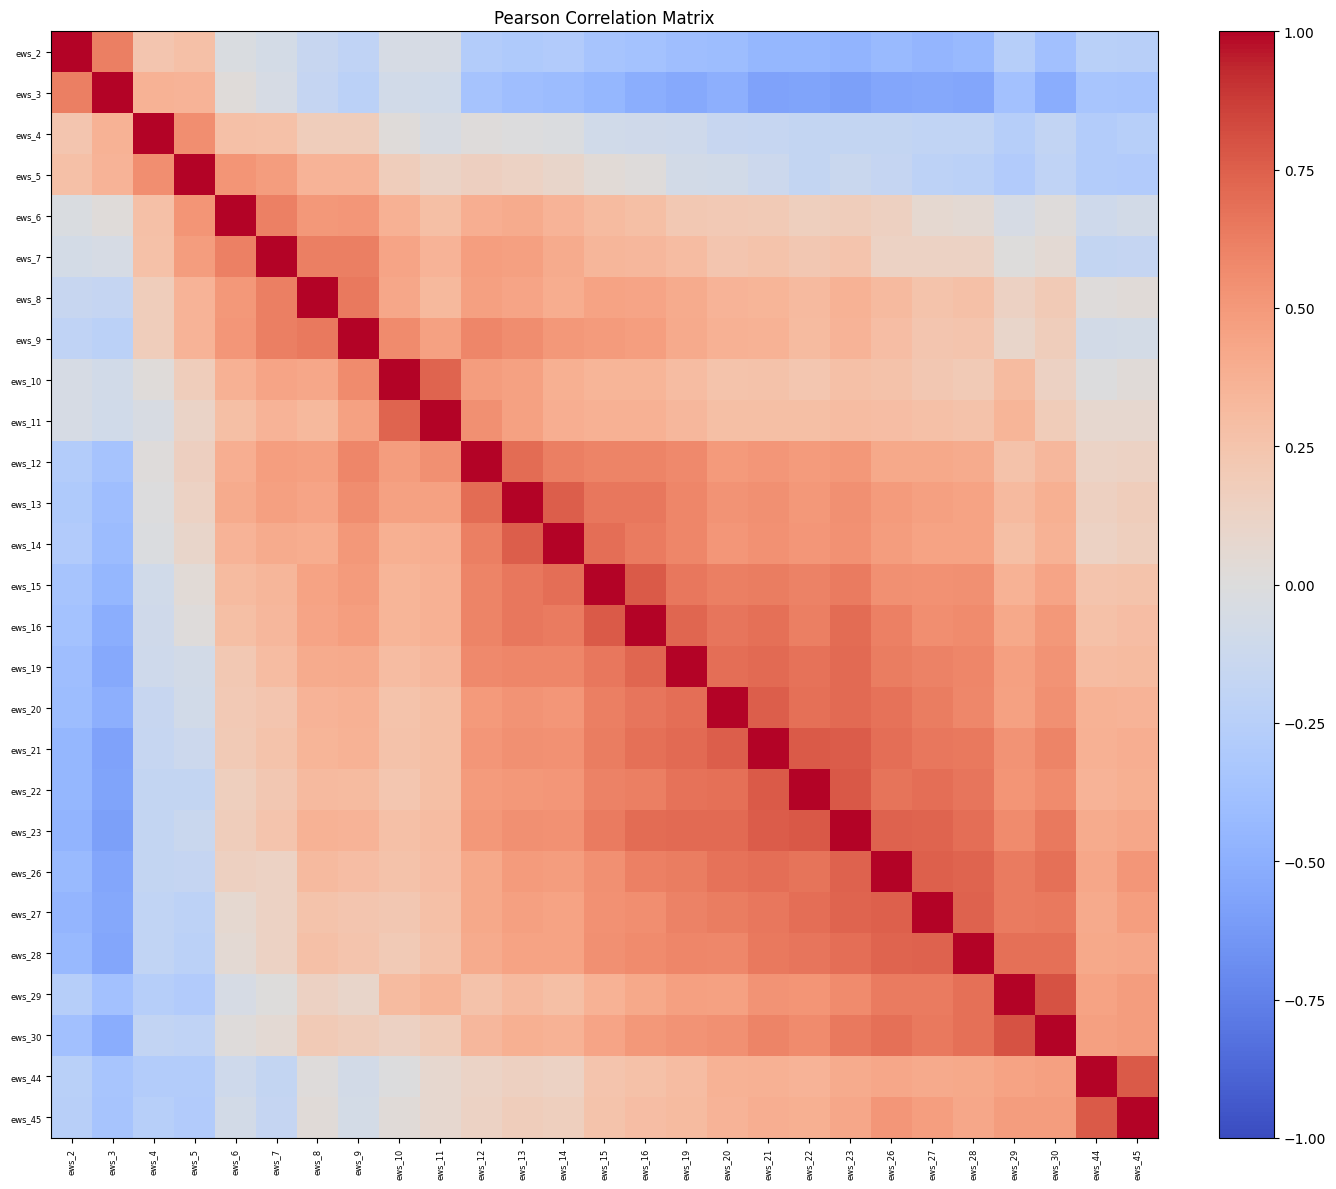

In [ ]:
import matplotlib.pyplot as plt

y = df_featurized_ews['density']
X_all_struc = df_featurized_ews.drop(columns=['density', 'structure'])

# Keep only numeric columns
X_all_struc = X_all_struc.select_dtypes(include=[float, int])
print("Number of numeric features before cleaning:", X_all_struc.shape[1])

# Identify columns with very small variance and drop them
small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols_struc)
X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)

# Compute correlation matrix
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

# Remove highly correlated columns
threshold = 0.80                     #lowered the threshold as a cheap way of eliminating features, lol
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[
        (corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)
    ]
    to_drop_struc.update(high_corr_struc)
print("Columns to drop due to high correlation:", to_drop_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

# Plot correlation matrix
corr_matrix_struc = X_struc.corr(method='pearson')
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()


In [ ]:
# SPLIT INTO TRAIN VALIDATION AND TEST
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [ ]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting density): {baseline_mae:.4f} ")

Baseline MAE (predicting density): 2.1420 


#### Going to optimize n_estimators, max_depth, and max_features (in a somewhat jank way, I'm doing it one at a time even though they are all dependent on each other)

Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

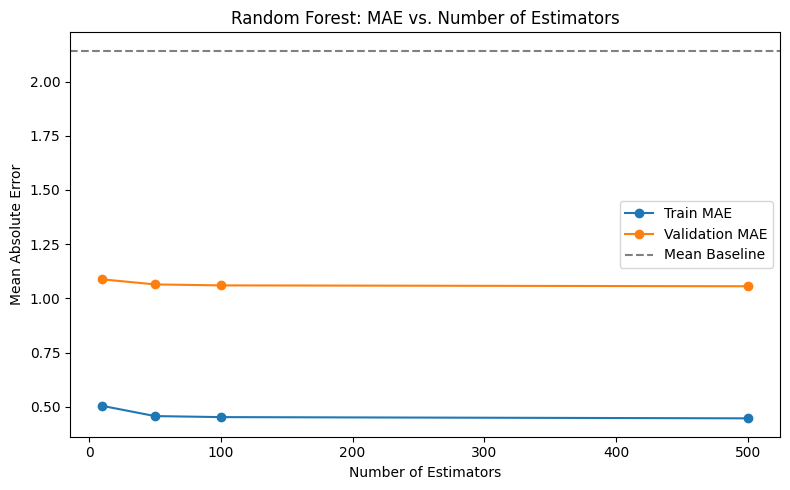

In [ ]:
#OPTIMIZE N_ESTIMATORS
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

Optimizing max_depth:   0%|          | 0/3 [00:00<?, ?it/s]

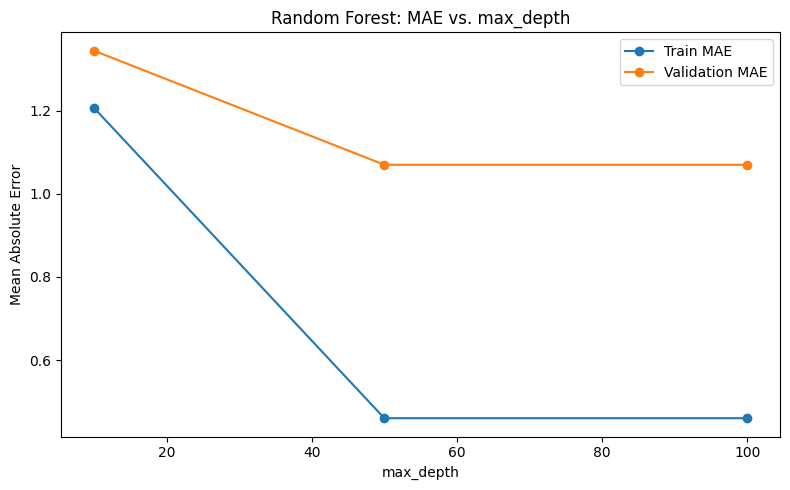

In [ ]:
#OPTIMIZE MAX_DEPTH
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Keep n_estimators and max_features fixed
n_estimators_fixed = 50
max_features_fixed = 5

max_depth_list = [10, 50, 100]  # choose 2 values
train_maes = []
val_maes = []

for md in tqdm(max_depth_list, desc='Optimizing max_depth'):
    rf = RandomForestRegressor(
        n_estimators=n_estimators_fixed,
        max_features=max_features_fixed,
        max_depth=md,
        random_state=17,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8,5))
plt.plot(max_depth_list, train_maes, marker='o', label='Train MAE')
plt.plot(max_depth_list, val_maes, marker='o', label='Validation MAE')
plt.xlabel('max_depth')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. max_depth')
plt.legend()
plt.tight_layout()
plt.show()


Optimizing max_features:   0%|          | 0/3 [00:00<?, ?it/s]

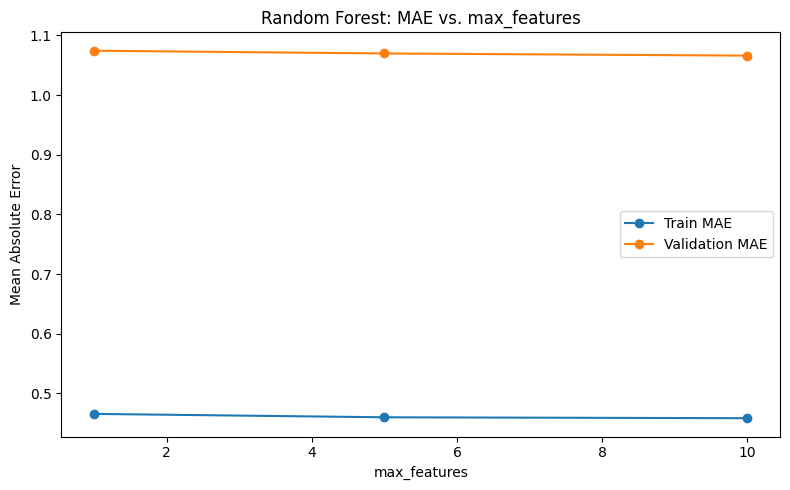

In [ ]:
# Keep n_estimators and max_depth fixed
n_estimators_fixed = 50
max_depth_fixed = 50

max_features_list = [1, 5, 10]  # choose 2 values, sqrt(features) and ALL FEATURES
train_maes = []
val_maes = []

for mf in tqdm(max_features_list, desc='Optimizing max_features'):
    rf = RandomForestRegressor(
        n_estimators=n_estimators_fixed,
        max_features=mf,
        max_depth=max_depth_fixed,
        random_state=17,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8,5))
plt.plot(max_features_list, train_maes, marker='o', label='Train MAE')
plt.plot(max_features_list, val_maes, marker='o', label='Validation MAE')
plt.xlabel('max_features')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. max_features')
plt.legend()
plt.tight_layout()
plt.show()


#### after a jank hyperparameter optimization, I choose n_estimators=50, max_depth=50, max_features=5

RFE Progress:   0%|          | 0/27 [00:00<?, ?it/s]

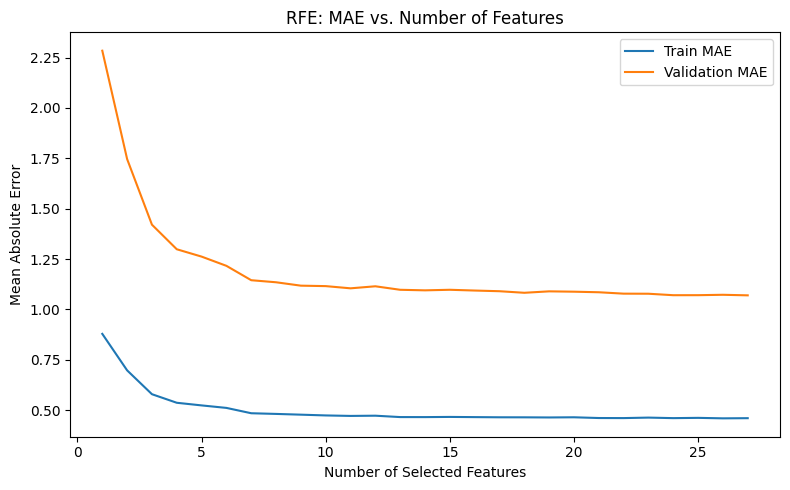

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=50, max_depth=50, max_features=5, random_state=17, n_jobs=1)
n_features_list = list(range(1, X_val.shape[1]+1, 1))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X_struc.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

#### necessary number of features = 10, now fit model

In [ ]:
# USE ONLY 10 FEATURES
from sklearn.model_selection import train_test_split

# Ensure X_struc is a DataFrame
X_train, X_temp, y_train, y_temp = train_test_split(X_struc, y, test_size=0.3, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17)

# Get the top 10 features selected by RFE
top_10_features = selected_features_dict[10]  # 10 is the optimal number of features

# Subset your X_train, X_val, X_test to these features
X_train_top10 = X_train[top_10_features]
X_val_top10 = X_val[top_10_features]
X_test_top10 = X_test[top_10_features]


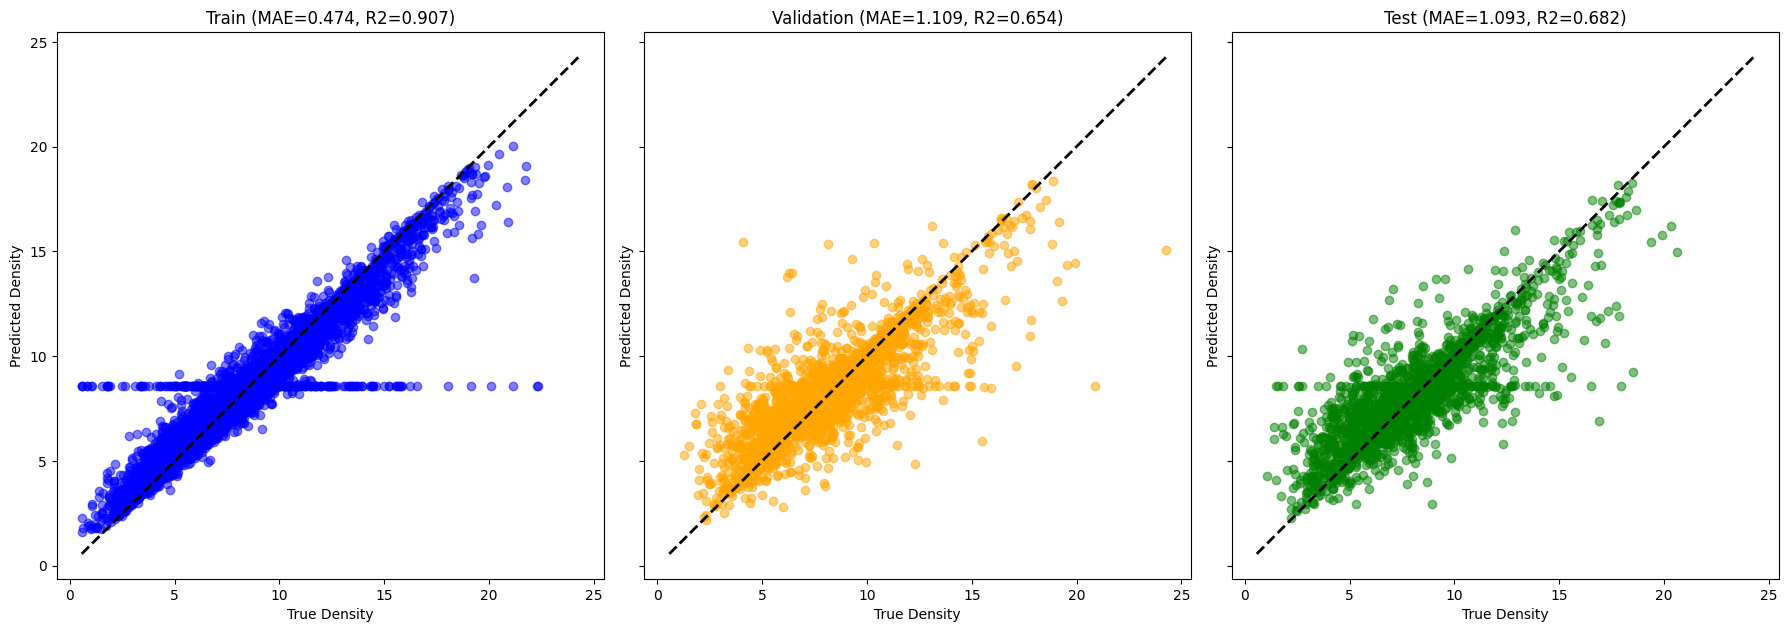

In [ ]:
#FINAL PARITY PLOTS
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
rf_final.fit(X_train_top10, y_train)

# Make predictions
y_train_pred = rf_final.predict(X_train_top10)
y_val_pred = rf_final.predict(X_val_top10)
y_test_pred = rf_final.predict(X_test_top10)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Parity plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val, max_val = min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Density')
axes[0].set_ylabel('Predicted Density')
axes[0].set_aspect('equal', adjustable='box')

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Density')
axes[1].set_ylabel('Predicted Density')
axes[1].set_aspect('equal', adjustable='box')

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Density')
axes[2].set_ylabel('Predicted Density')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


# Assignment 3

#### *annotated copy of the article in my repository*

#### **The Crucial Role and Requirements of Structural Representations:** The construction of a suitable representation is the indispensable first step in using machine-learning methods to predict or analyze relationships between atomic-scale structure and properties

#### **Symmetry Dictates Representation Frameworks:** Symmetry is a central principle in the development of atomistic machine-learning schemes, allowing for a "phylogenetic tree" organization

#### **The Importance of Locality and Additivity for Model Transferability:** Many successful machine-learning models for interatomic potentials rely on the assumption of additivity, wherein a global property (like molecular energy) is decomposed into a sum of local, atom-centered contributions

#### **Smoothness** and the Pitfalls of Sorting-Based Invariance: Function regularity, or smoothness, is crucial for creating efficient machine-learning models, and features built from a smeared atom density are naturally smooth functions of coordinates